<a href="https://colab.research.google.com/github/SkAztecs/Ieee-Task-ML/blob/main/IEEE_CS_ML_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking Data. Not uploading mp4.

In [ ]:
!ls -l /content/.kaggle




total 4
-rw-r--r-- 1 root root 69 Dec 30 13:28 kaggle.json


In [ ]:
!chmod 600 /content/.kaggle/kaggle.json


In [ ]:
!ls -l /content/.kaggle


total 4
-rw------- 1 root root 69 Dec 30 13:28 kaggle.json


In [ ]:
!kaggle datasets list


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
!mkdir -p /root/.config/kaggle


In [ ]:
!mv /content/.kaggle/kaggle.json /root/.config/kaggle/


In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json


In [ ]:
!ls -l /root/.config/kaggle


total 4
-rw------- 1 root root 69 Dec 30 13:28 kaggle.json


In [12]:
!kaggle datasets list


ref                                                   title                                           size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ----------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                              Heart Disease                                   3491  2025-12-11 15:29:14.327000           2114        130  1.0              
wardabilal/spotify-global-music-dataset-20092025      Spotify Global Music Dataset (2009–2025)     1289021  2025-11-11 09:43:05.933000          16387        463  1.0              
neurocipher/student-performance                       Student Performance                            49705  2025-12-12 12:06:28.973000           1261         93  1.0              
suvidyasonawane/student-performance-dataset           Student Performance Dataset                   

In [13]:
import cv2

In [14]:
print(cv2.__version__)

4.12.0


In [15]:
import os
import matplotlib.pyplot as plt

In [17]:
fake_path = "train/fake"
print(os.listdir(fake_path)[:5])


['47091d45c0c041e29ac4fcb9b2a674b6.mp4', 'd7d938279e43488cb35d304c1fedf228.mp4', '00469837ba4849189cbf35c65089ee55.mp4', '6b1c9e6e33084e3ea1cc0f37842b9ffd.mp4', '6bd2de8a1b1c4666b506d66865d25317.mp4']


In [18]:
video_path = os.path.join(fake_path, os.listdir(fake_path)[0])
print(video_path)

train/fake/47091d45c0c041e29ac4fcb9b2a674b6.mp4


In [19]:
cap = cv2.VideoCapture(video_path)


In [21]:
ret, frame = cap.read()
print("Read success:", ret)

Read success: True


(np.float64(-0.5), np.float64(853.5), np.float64(479.5), np.float64(-0.5))

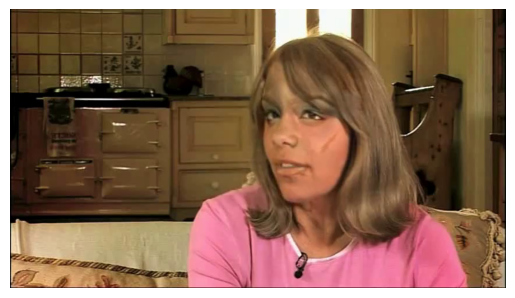

In [22]:
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)
plt.axis("off")

In [23]:
cap.release()

We need this to convert to numericfeatures to progress
so doing this

video.mp4
   ->
sample frames
   ->
resize (224×224)
   ->
CNN feature extractor
   ->
feature vectors
   ->
average
   ->
one vector per video

Load MobileNetV2 to do this

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)

/tmp/ipython-input-1832084246.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
